
# aSPEM Experiment : analysis

https://scikit-learn.org/stable/auto_examples/neighbors/plot_nearest_centroid.html#sphx-glr-auto-examples-neighbors-plot-nearest-centroid-py




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%load_ext autoreload
%autoreload 2
#from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from aSPEM import aSPEM
import bayesianchangepoint as bcp

%matplotlib inline

In [2]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [3]:
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']

nb_sujet = len(list_sujet)
COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan'] #[(0+(1/nb_sujet)*n, 0, 0, 0.5) for n in range(nb_sujet)]

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [5]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

## Data Scalling

## Find h

In [ ]:
with open('H_mean.pkl', 'rb') as fichier :
    H_ = pickle.load(fichier, encoding='latin1')
h_bet_m, h_va_m = H_['h_bet'], H_['h_va']

with open('H_leaky.pkl', 'rb') as fichier :
    H_ = pickle.load(fichier, encoding='latin1')
h_bet_l, h_va_l = H_['h_bet'], H_['h_va']


# Classifier

In [8]:
COLOR = ['crimson', 'saddlebrown', 'grey', 'darkseagreen', 'dimgrey', 'r',
         'slateblue', 'w', 'peru', 'darkolivegreen', 'goldenrod', 'c']

from matplotlib.colors import ListedColormap
cmap = ListedColormap(COLOR)

In [9]:
def find_X(h_bet, h_va, log=False) :
    X, y = [[],[]], []
    for s, suj in enumerate(list_sujet) :
        for b in range(len(h_bet[suj])) :
            y.append(s)
            if log is True : X[0].append(np.log10(h_bet[suj][b])) ; X[1].append(np.log10(h_va[suj][b]))
            else :           X[0].append(h_bet[suj][b]) ;           X[1].append(h_va[suj][b])
                   
    X = np.array(X) ; X = X.transpose()
    y = np.array(y)
    return X, y

#TODO prune methods
#TODO plots: loglog + centrer
#TODO cross-validation LOO
#TODO compare with fixed / real --> change fixed_window_size au lieu de h pour leaky


In [10]:
def Classifier(X, y) :

    r_s = 0
    
    dim_red = [('None', X)]
    
    from sklearn import preprocessing as pre
    dim_red.append(('StandardScaler',   pre.StandardScaler()))
    #dim_red.append(('Quantile_normal',  pre.QuantileTransformer(output_distribution='normal', n_quantiles=int(132/5))))
    dim_red.append(('Quantile_uniform', pre.QuantileTransformer(output_distribution='uniform', n_quantiles=int(132/5))))
    #dim_red.append(('RobustScaler',     pre.RobustScaler(quantile_range=(25, 75))))
    #dim_red.append(('PowerTransformer', pre.PowerTransformer(method='yeo-johnson')))

    
    CLF = []
    
    from sklearn import ensemble
    CLF.append(('AdaBoost',         ensemble.AdaBoostClassifier(random_state=r_s)))
    CLF.append(('Bagging',          ensemble.BaggingClassifier(random_state=r_s)))
    CLF.append(('ExtraTrees',       ensemble.ExtraTreesClassifier(random_state=r_s, n_estimators=100)))
    #CLF.append(('GradientBoosting', ensemble.GradientBoostingClassifier(random_state=r_s)))
    CLF.append(('RandomForest',     ensemble.RandomForestClassifier(random_state=r_s, n_estimators=100)))

    from sklearn.gaussian_process import GaussianProcessClassifier
    CLF.append(('GaussianProcess', GaussianProcessClassifier(random_state=r_s)))
    
    from sklearn import linear_model
    CLF.append(('LogisticRegression',   linear_model.LogisticRegression(random_state=r_s,
                                                                        multi_class='auto',
                                                                        solver='lbfgs')))
    CLF.append(('LogisticRegressionCV', linear_model.LogisticRegressionCV(random_state=r_s,
                                                                          multi_class='auto',
                                                                          cv=5,
                                                                          max_iter=1500)))
    CLF.append(('PassiveAggressive',    linear_model.PassiveAggressiveClassifier(random_state=r_s)))
    CLF.append(('Ridge',                linear_model.RidgeClassifier(random_state=r_s)))
    CLF.append(('RidgeCV',              linear_model.RidgeClassifierCV()))
    CLF.append(('SGD',                  linear_model.SGDClassifier(random_state=r_s)))
    
    #from sklearn import naive_bayes
    #CLF.append(('BernoulliNB', naive_bayes.BernoulliNB()))
    #CLF.append(('MultinomialNB', naive_bayes.MultinomialNB()))
    #CLF.append(('ComplementNB',  naive_bayes.ComplementNB()))

    from sklearn import neighbors
    CLF.append(('KNeighbors',      neighbors.KNeighborsClassifier()))
    CLF.append(('NearestCentroid', neighbors.NearestCentroid()))
    #CLF.append(('RadiusNeighborsClassifier', neighbors.RadiusNeighborsClassifier()))
    
    from sklearn import neural_network
    CLF.append(('MLPClassifier', neural_network.MLPClassifier(random_state=r_s, max_iter=3000)))
    
    from sklearn import semi_supervised
    CLF.append(('LabelPropagation', semi_supervised.LabelPropagation()))
    
    from sklearn import svm
    CLF.append(('LinearSVC', svm.LinearSVC(random_state=r_s, max_iter=1500)))
    CLF.append(('NuSVC',     svm.NuSVC(random_state=r_s, gamma='scale')))
    CLF.append(('SVC',       svm.SVC(random_state=r_s, gamma='scale')))
    
    #from sklearn import tree
    #CLF.append(('DecisionTree', tree.DecisionTreeClassifier()))
    #CLF.append(('ExtraTree',    tree.ExtraTreeClassifier()))
    
    '''
    CLF.append(('LinearSVC',  svm.LinearSVC(C=1., max_iter=10000)))
    CLF.append(('SVC_linear', svm.SVC(kernel='linear', C=1.)))    
    CLF.append(('SVC_rbf',    svm.SVC(kernel='rbf', gamma=0.7, C=1.)))
    CLF.append(('SVC_poly',   svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.)))
    '''
    
    for c, (NAME, clf) in enumerate(CLF) :
        fig, axs = plt.subplots(1, len(dim_red), figsize=(20,20/len(dim_red)))

        for i, (name, model) in enumerate(dim_red):
        
            try :
                if name=='None' :        X_t = X
                else : model.fit(X, y) ; X_t = model.transform(X)
                clf.fit(X_t, y)
                
                from sklearn.model_selection import (cross_val_score, LeaveOneOut)
                acc_knn = cross_val_score(clf, X_t, y, cv=LeaveOneOut())
                #acc_knn = clf.score(X_t, y)

                y_pred = clf.predict(X_t)
                x_min, x_max = X_t[:, 0].min(), X_t[:, 0].max()
                y_min, y_max = X_t[:, 1].min(), X_t[:, 1].max()

                if name == 'NCA' : h=0.2
                else :             h=0.01
                xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/500),
                                     np.arange(y_min, y_max, (y_max-y_min)/500))
                Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)

                axs[i].pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.5)
                axs[i].scatter(X_t[:, 0], X_t[:, 1], c=y, s=50, edgecolors='k', cmap=cmap)
                axs[i].set_title("classifier : %s\nnormalisation : %s\nTest accuracy = %.2f (+/- %.2f)"%(NAME, name,
                                                                                                         acc_knn.mean(),
                                                                                                         acc_knn.std()))
            except : pass
        plt.show()

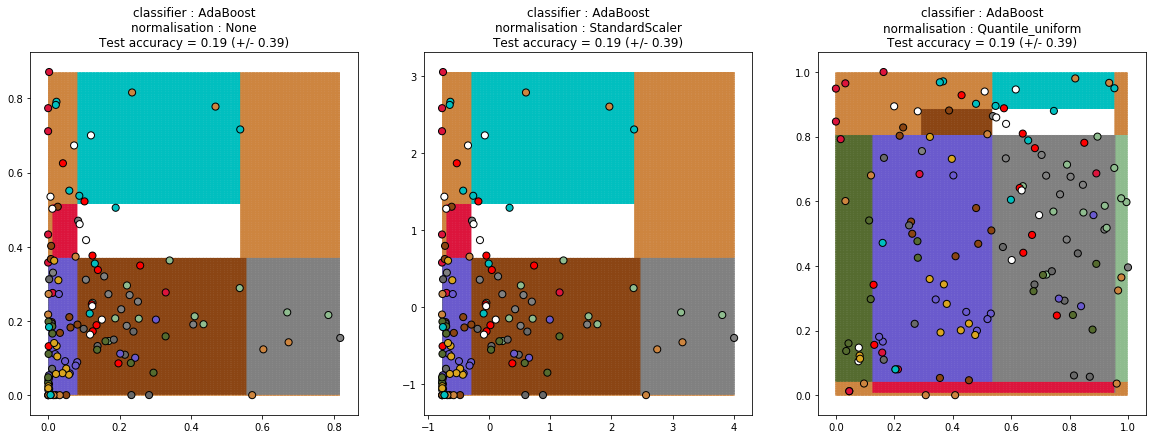

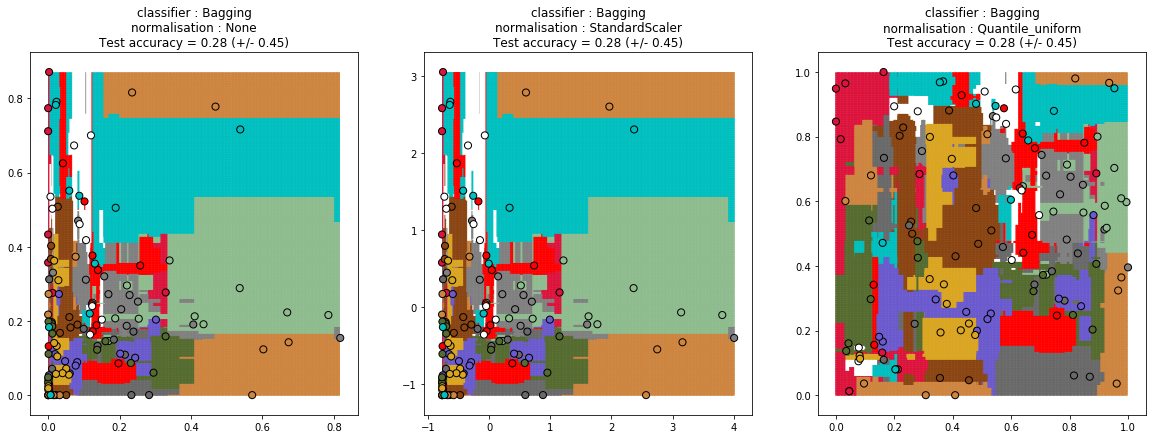

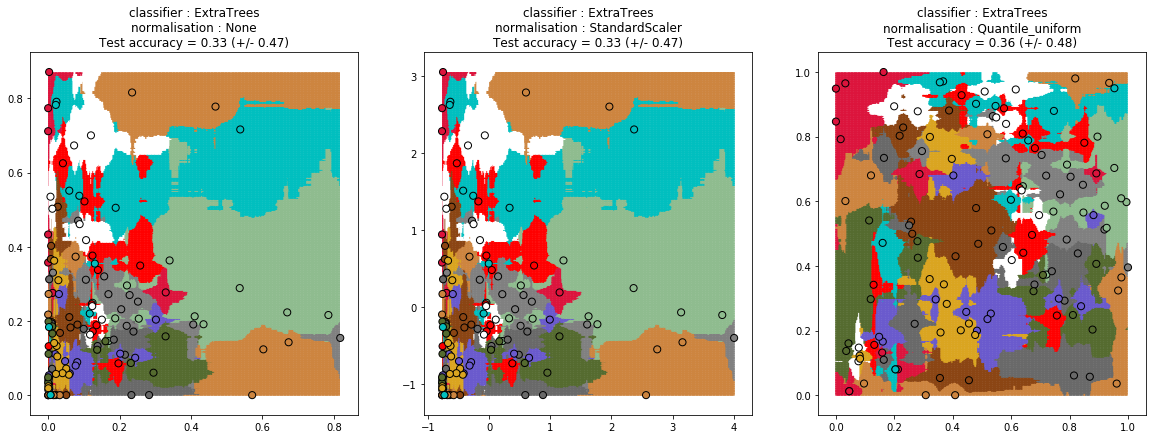

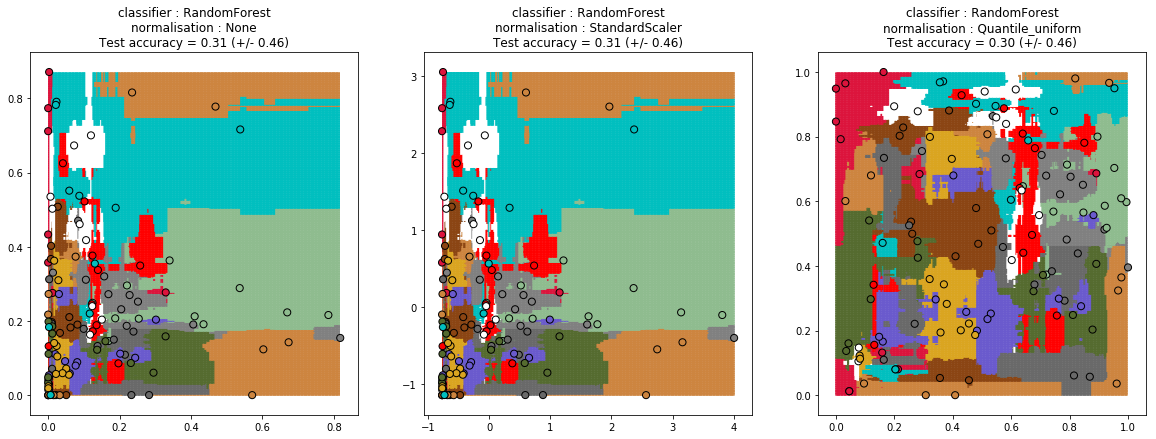

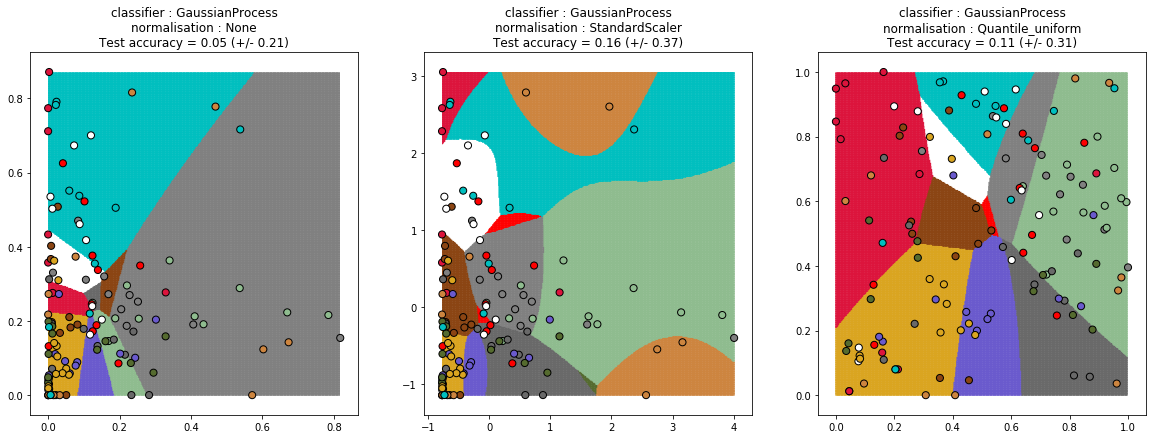

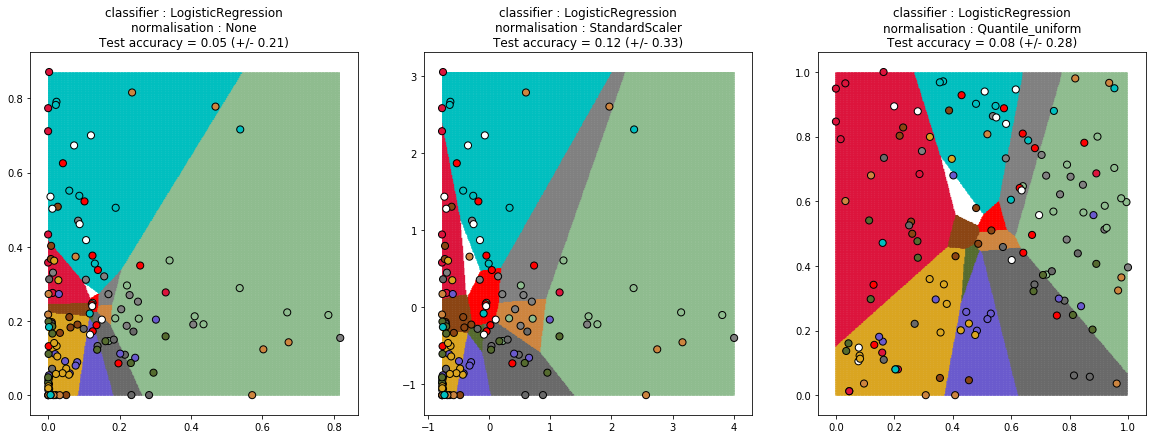

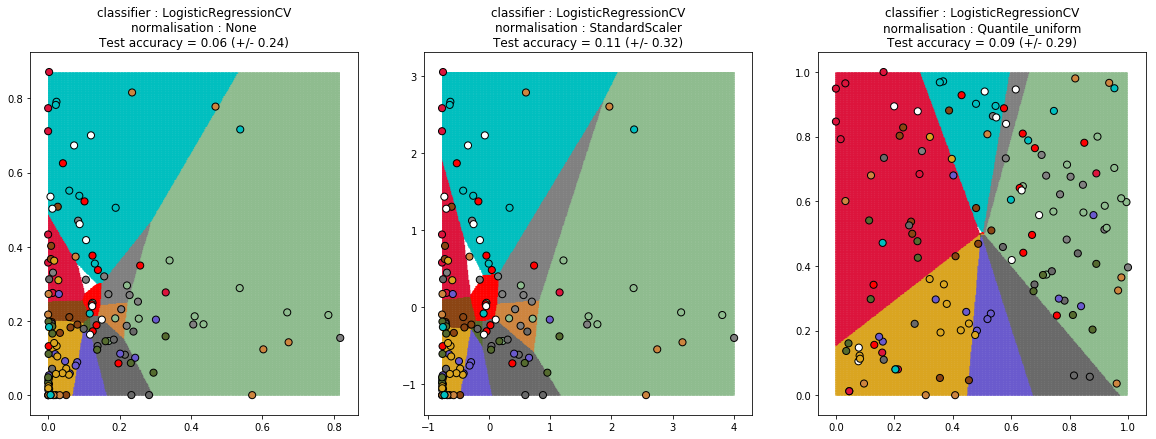

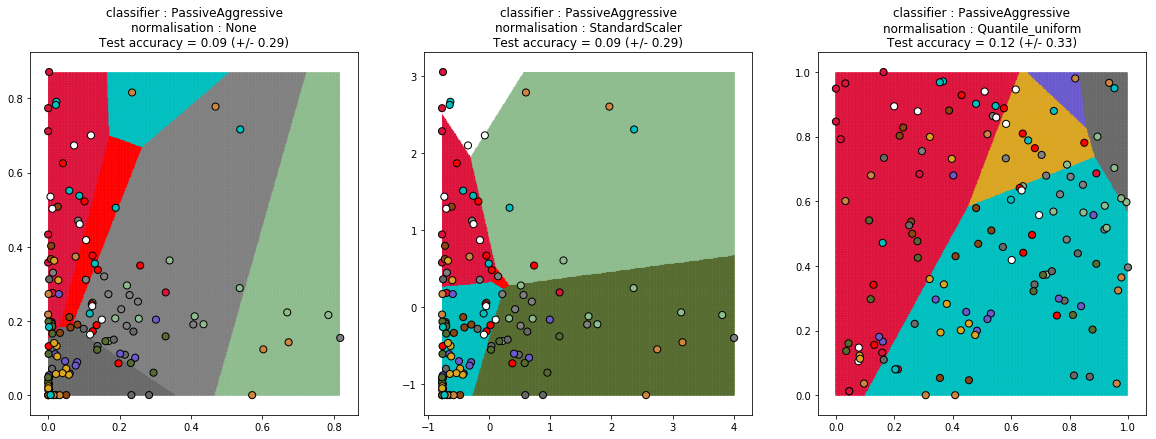

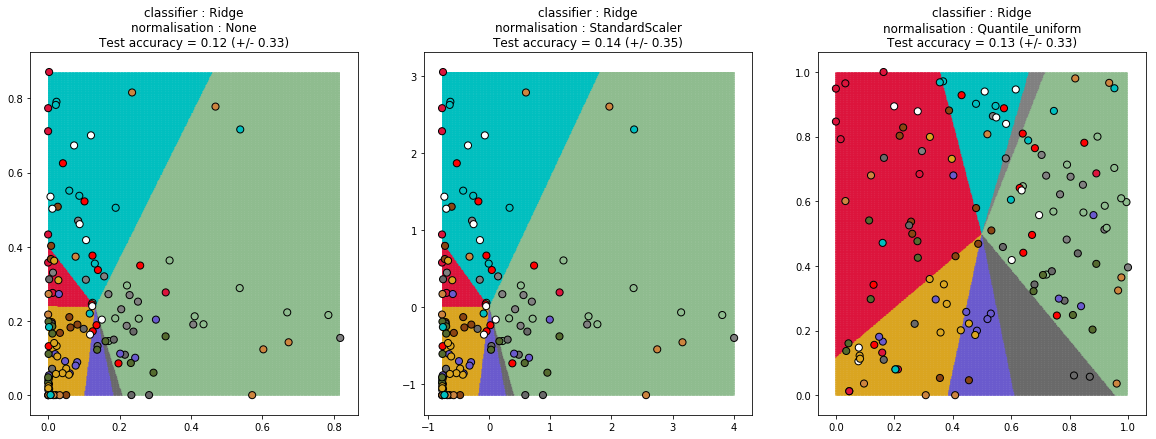

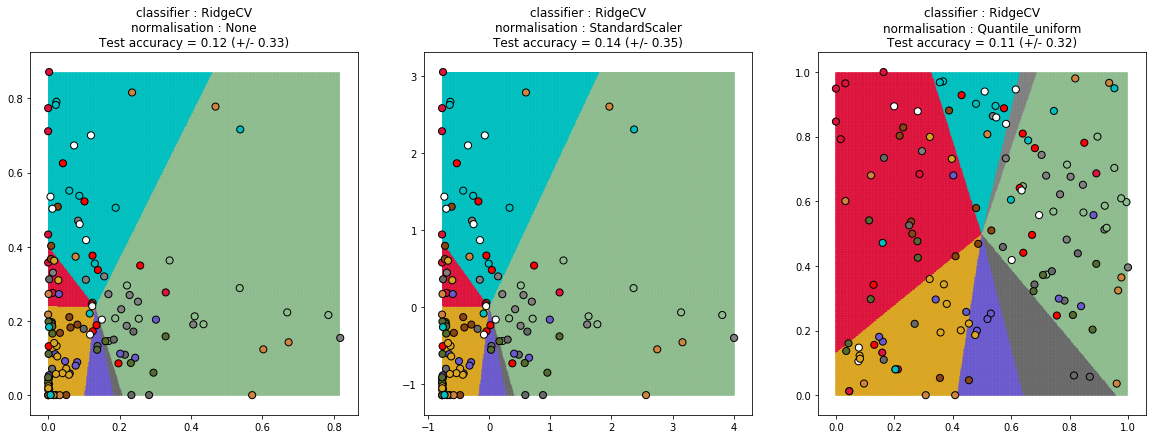

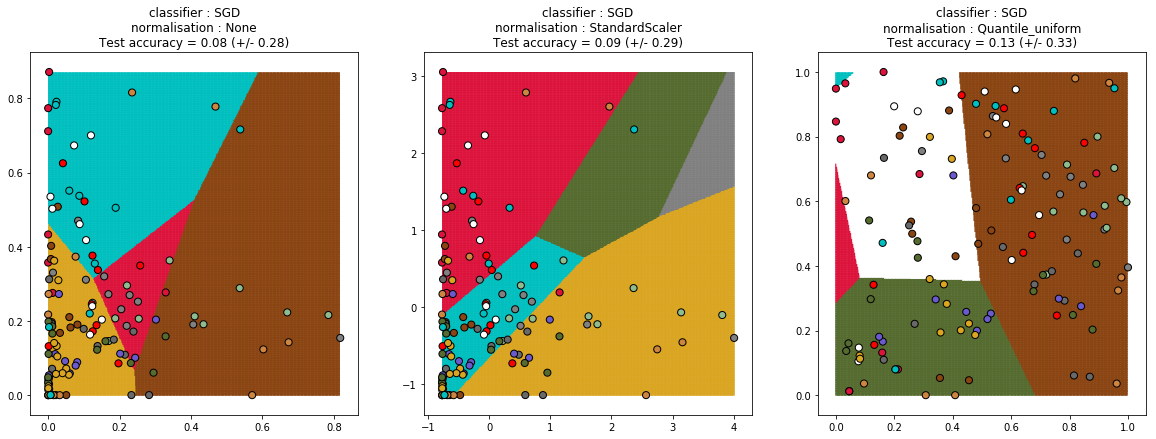

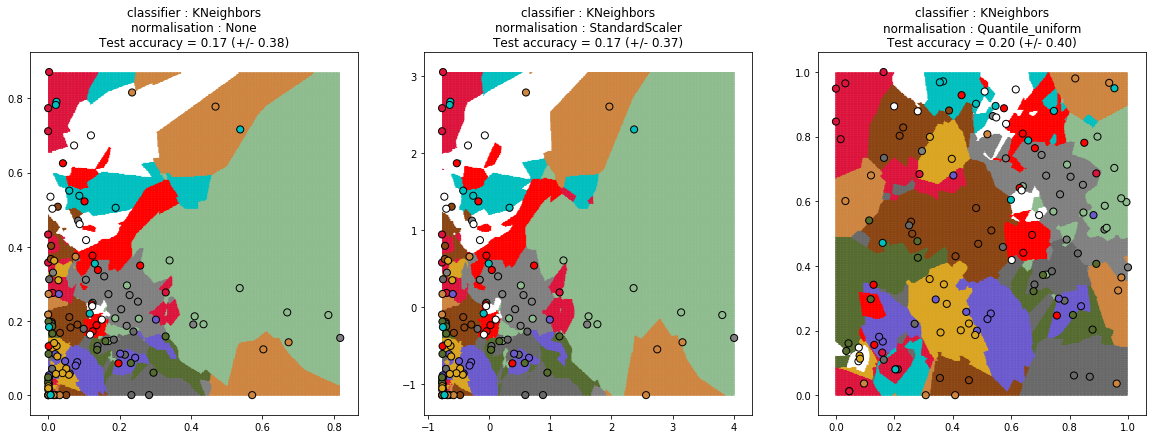

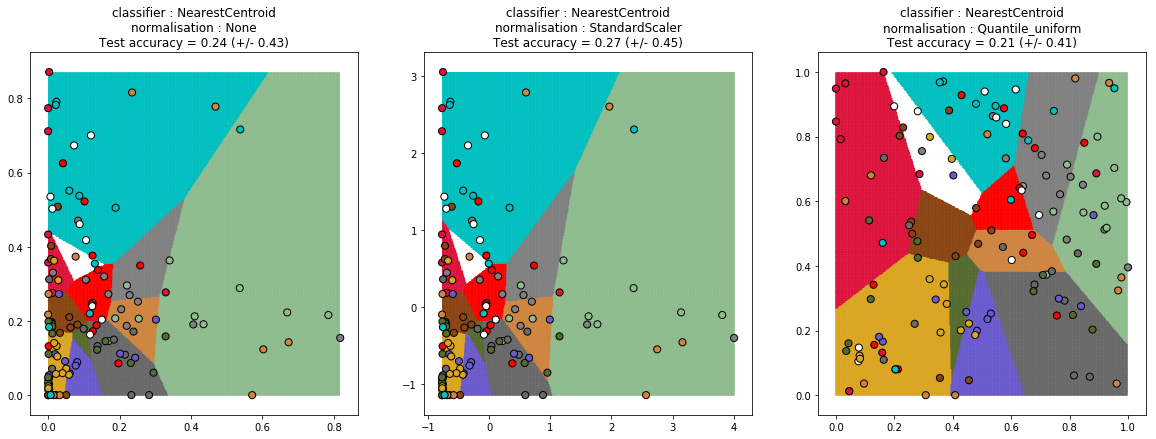

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


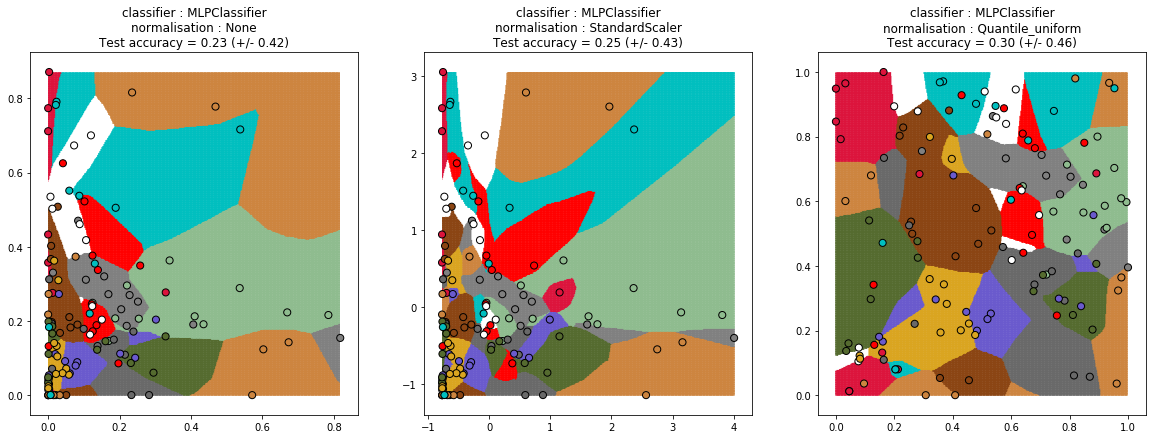

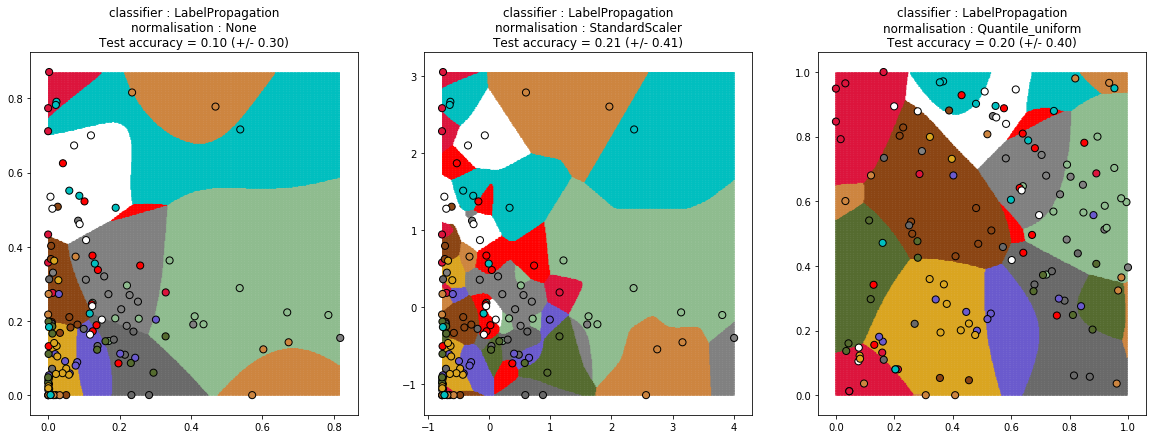

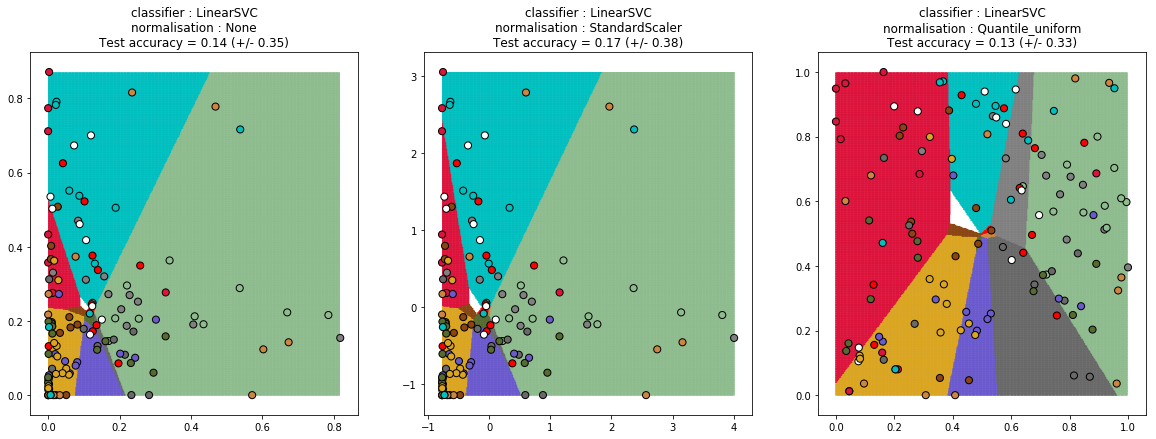

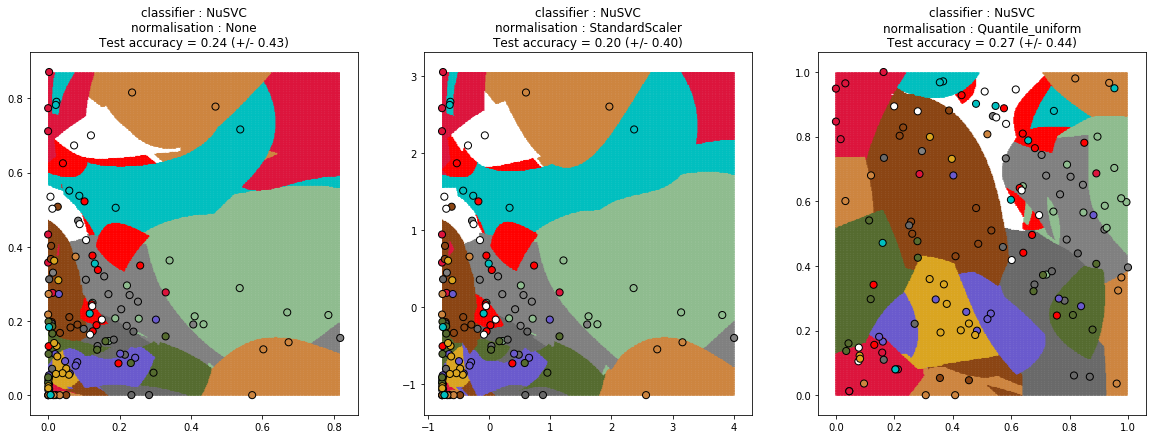

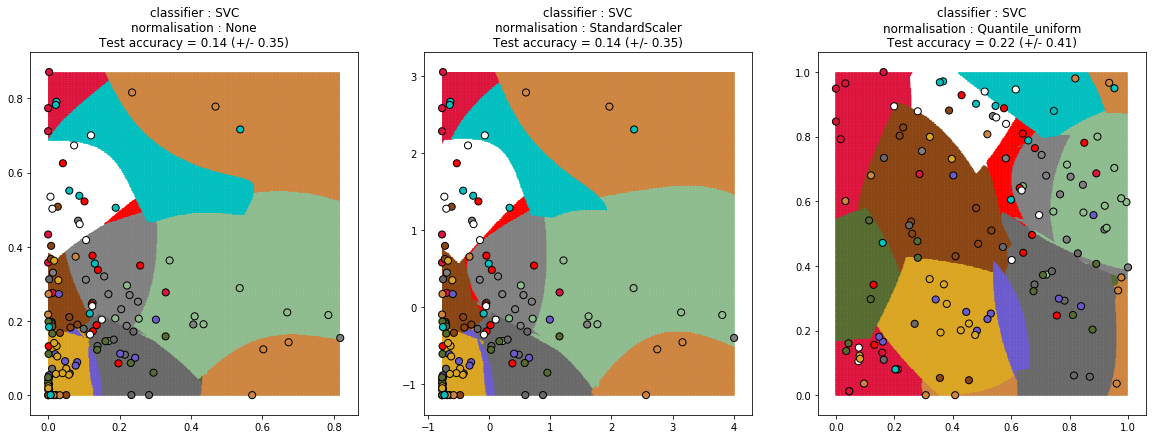

In [11]:
X, y = find_X(h_bet_m['100'], h_va_m['100'], log=False)
Classifier(X, y)